In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)


cpu


# Model definition

In [4]:
torch.manual_seed(0) #get the same random numbers everytime you run the code
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

t_span = (0, 10) #wanted timespan
n_step = 100 #number of steps to train the data (number of initial conditions)
n_data = 1000 #number of data per step (per initial condition, this number of datapoints to train, validate, test data)

#validation set will be used to choose hyperparameters, decide when to stop training, compare multiple models fairly and detect overfitting
train, validation, test = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

In [5]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, hidden_sizes, activation):
        super().__init__()
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }

        #allow for different sizes of neurons for each layer
        layer_sizes = [n_in] + hidden_sizes + [1] #becomes for example [4, 64, 32, 16, 1]
        
        self.net = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes)-1)
        ]) #nn.Linear(4, 64), nn.Linear(64, 32), ..., nn.Linear(16, 1)

        self.activation = act[activation] #chooses a value from the dictionary, e.g. act['tanh']

    def forward(self, x):
        for layer in self.net[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.net[-1](x)

# test model
model = HarmonicModel(
    n_in=4,
    hidden_sizes=[64, 32, 16],   # ← arbitrary shapes
    activation='tanh'
).to(device)

In [6]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    return mse_y

In [7]:
#train model
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)
    
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model #return trained model, not final loss

#evaluate model
def evaluate_harmonic(model, data):
    model.eval()
    X_val = data["X"].to(device)
    y_val = data["y_tensor"][:, :, 0].to(device)

    t = X_val[:, :, 3]
    k = X_val[:, :, 0]
    x_00 = X_val[:, :, 1]
    x_01 = X_val[:, :, 2]

    with torch.no_grad():
        y_pred = model(X_val).squeeze(-1)
        loss = loss_harmonic(y_pred, y_val, x_00, x_01, t, k, N_f=1000)

    return loss.item()

# Hyperparameter optimization

## 1) Using random hyperparameter search

In [8]:
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, lr_i: tuple, train_data, val_data, seed=0, device='cpu'):
    torch.manual_seed(seed)
    random.seed(seed)
    result = []

    for _ in tqdm(range(n_trials), desc="Hyperparameter search"):
        n_layers = random.randint(layers_i[0], layers_i[1])  # inclusive

        hidden_sizes = [
            random.randint(neurons_i[0], neurons_i[1])
            for _ in range(n_layers)
        ]

        activation = random.choice(activations_l)

        lr = 10 ** random.uniform(
            torch.log10(torch.tensor(lr_i[0])).item(),
            torch.log10(torch.tensor(lr_i[1])).item()
        )

        params = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'lr': lr
        }

        model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)
        #train_model
        train_harmonic(model, lr=lr, epochs=100, data=train_data)

        #evaluate on validation data
        val_loss = evaluate_harmonic(model,data=val_data)

        result.append((params, val_loss))
    
    return result

In [9]:
n_trials = 50
results_opt_rand = rng_hparameters_search(n_trials,
                                 layers_i=(2, 5),
                                 neurons_i=(16, 128),
                                 activations_l=['tanh', 'sine', 'gelu', 'relu'],
                                 lr_i= (1e-4, 1e-2),
                                 train_data = train,
                                 val_data = validation, 
                                 device=device,
                                 seed=0)

Hyperparameter search:   0%|          | 0/50 [00:00<?, ?it/s]

Hyperparameter search:   2%|▏         | 1/50 [00:15<12:55, 15.82s/it]

Epoch 100/100, Loss: 0.4193


Hyperparameter search:   4%|▍         | 2/50 [00:26<10:00, 12.52s/it]

Epoch 100/100, Loss: 0.6146


Hyperparameter search:   6%|▌         | 3/50 [00:36<08:59, 11.48s/it]

Epoch 100/100, Loss: 0.1388


Hyperparameter search:   8%|▊         | 4/50 [00:43<07:32,  9.83s/it]

Epoch 100/100, Loss: 0.3423


Hyperparameter search:  10%|█         | 5/50 [00:53<07:21,  9.82s/it]

Epoch 100/100, Loss: 0.5449


Hyperparameter search:  12%|█▏        | 6/50 [01:03<07:13,  9.85s/it]

Epoch 100/100, Loss: 0.8022


Hyperparameter search:  14%|█▍        | 7/50 [01:08<06:00,  8.38s/it]

Epoch 100/100, Loss: 0.5403


Hyperparameter search:  16%|█▌        | 8/50 [01:14<05:14,  7.48s/it]

Epoch 100/100, Loss: 0.7056


Hyperparameter search:  18%|█▊        | 9/50 [01:27<06:15,  9.16s/it]

Epoch 100/100, Loss: 0.5895


Hyperparameter search:  20%|██        | 10/50 [01:41<07:08, 10.72s/it]

Epoch 100/100, Loss: 0.7461


Hyperparameter search:  22%|██▏       | 11/50 [01:59<08:30, 13.08s/it]

Epoch 100/100, Loss: 0.1590


Hyperparameter search:  24%|██▍       | 12/50 [02:06<07:05, 11.21s/it]

Epoch 100/100, Loss: 0.1521


Hyperparameter search:  26%|██▌       | 13/50 [02:17<06:54, 11.19s/it]

Epoch 100/100, Loss: 0.5428


Hyperparameter search:  28%|██▊       | 14/50 [02:23<05:42,  9.52s/it]

Epoch 100/100, Loss: 0.7738


Hyperparameter search:  30%|███       | 15/50 [02:36<06:10, 10.58s/it]

Epoch 100/100, Loss: 0.1749


Hyperparameter search:  32%|███▏      | 16/50 [02:41<05:01,  8.86s/it]

Epoch 100/100, Loss: 0.3524


Hyperparameter search:  34%|███▍      | 17/50 [03:03<07:04, 12.85s/it]

Epoch 100/100, Loss: 0.0354


Hyperparameter search:  36%|███▌      | 18/50 [03:19<07:20, 13.77s/it]

Epoch 100/100, Loss: 0.8370


Hyperparameter search:  38%|███▊      | 19/50 [03:29<06:36, 12.79s/it]

Epoch 100/100, Loss: 0.1378


Hyperparameter search:  40%|████      | 20/50 [03:38<05:43, 11.46s/it]

Epoch 100/100, Loss: 0.5790


Hyperparameter search:  42%|████▏     | 21/50 [03:48<05:22, 11.12s/it]

Epoch 100/100, Loss: 0.7464


Hyperparameter search:  44%|████▍     | 22/50 [04:01<05:23, 11.56s/it]

Epoch 100/100, Loss: 0.3026


Hyperparameter search:  46%|████▌     | 23/50 [04:03<03:58,  8.83s/it]

Epoch 100/100, Loss: 0.6155


Hyperparameter search:  48%|████▊     | 24/50 [04:07<03:13,  7.44s/it]

Epoch 100/100, Loss: 0.2756


Hyperparameter search:  50%|█████     | 25/50 [04:11<02:41,  6.46s/it]

Epoch 100/100, Loss: 0.7872


Hyperparameter search:  52%|█████▏    | 26/50 [04:19<02:41,  6.72s/it]

Epoch 100/100, Loss: 0.2517


Hyperparameter search:  54%|█████▍    | 27/50 [04:23<02:17,  5.96s/it]

Epoch 100/100, Loss: 0.6343


Hyperparameter search:  56%|█████▌    | 28/50 [04:29<02:12,  6.04s/it]

Epoch 100/100, Loss: 0.6680


Hyperparameter search:  58%|█████▊    | 29/50 [04:36<02:09,  6.17s/it]

Epoch 100/100, Loss: 0.6330


Hyperparameter search:  60%|██████    | 30/50 [04:50<02:54,  8.75s/it]

Epoch 100/100, Loss: 0.4915


Hyperparameter search:  62%|██████▏   | 31/50 [05:03<03:07,  9.89s/it]

Epoch 100/100, Loss: 0.1686


Hyperparameter search:  64%|██████▍   | 32/50 [05:13<02:58,  9.91s/it]

Epoch 100/100, Loss: 0.2207


Hyperparameter search:  66%|██████▌   | 33/50 [05:19<02:27,  8.71s/it]

Epoch 100/100, Loss: 0.2600


Hyperparameter search:  68%|██████▊   | 34/50 [05:35<02:54, 10.93s/it]

Epoch 100/100, Loss: 0.7736


Hyperparameter search:  70%|███████   | 35/50 [05:45<02:41, 10.75s/it]

Epoch 100/100, Loss: 0.6534


Hyperparameter search:  72%|███████▏  | 36/50 [05:49<02:01,  8.65s/it]

Epoch 100/100, Loss: 0.6686


Hyperparameter search:  74%|███████▍  | 37/50 [06:05<02:21, 10.86s/it]

Epoch 100/100, Loss: 0.2806


Hyperparameter search:  76%|███████▌  | 38/50 [06:20<02:26, 12.17s/it]

Epoch 100/100, Loss: 0.3831


Hyperparameter search:  78%|███████▊  | 39/50 [06:27<01:55, 10.49s/it]

Epoch 100/100, Loss: 0.5180


Hyperparameter search:  80%|████████  | 40/50 [06:42<01:59, 11.95s/it]

Epoch 100/100, Loss: 0.1963


Hyperparameter search:  82%|████████▏ | 41/50 [06:46<01:24,  9.39s/it]

Epoch 100/100, Loss: 0.7696


Hyperparameter search:  84%|████████▍ | 42/50 [06:52<01:09,  8.63s/it]

Epoch 100/100, Loss: 0.4172


Hyperparameter search:  86%|████████▌ | 43/50 [07:05<01:09,  9.94s/it]

Epoch 100/100, Loss: 0.7858


Hyperparameter search:  88%|████████▊ | 44/50 [07:14<00:57,  9.61s/it]

Epoch 100/100, Loss: 0.1378


Hyperparameter search:  90%|█████████ | 45/50 [07:22<00:44,  8.94s/it]

Epoch 100/100, Loss: 0.1076


Hyperparameter search:  92%|█████████▏| 46/50 [07:29<00:33,  8.48s/it]

Epoch 100/100, Loss: 0.7045


Hyperparameter search:  94%|█████████▍| 47/50 [07:38<00:25,  8.50s/it]

Epoch 100/100, Loss: 0.6853


Hyperparameter search:  96%|█████████▌| 48/50 [07:45<00:16,  8.23s/it]

Epoch 100/100, Loss: 0.3896


Hyperparameter search:  98%|█████████▊| 49/50 [07:57<00:09,  9.33s/it]

Epoch 100/100, Loss: 0.7763


Hyperparameter search: 100%|██████████| 50/50 [08:04<00:00,  9.68s/it]

Epoch 100/100, Loss: 0.7759


## 2) Using Bayesian hyperparameter search

In [10]:
# Define your hyperparameter ranges and data
layers_i = (2, 5)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
lr_i = (1e-4, 1e-2)
train_data = train
val_data   = validation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial, layers_i, neurons_i, activations_l, lr_i, train_data, val_data):
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    hidden_sizes = [trial.suggest_int(f"neurons_l{i}", neurons_i[0], neurons_i[1]) for i in range(n_layers)]
    activation = trial.suggest_categorical("activation", activations_l)
    lr = trial.suggest_float("lr", lr_i[0], lr_i[1], log=True)


    model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)

    #train model
    train_harmonic(model, lr=lr, epochs=100, data=train_data)

    #evaluate model
    val_loss = evaluate_harmonic(model, data=val_data)

    return val_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective,
                                    layers_i=layers_i,
                                    neurons_i=neurons_i,
                                    activations_l=activations_l,
                                    lr_i=lr_i,
                                    train_data=train_data,
                                    val_data=val_data
                                    )

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=50)


[I 2025-12-04 15:48:08,568] A new study created in memory with name: no-name-cf8fd1fa-b816-4a4f-9946-25a6a41a2182
[I 2025-12-04 15:48:12,416] Trial 0 finished with value: 0.7654762864112854 and parameters: {'n_layers': 2, 'neurons_l0': 41, 'neurons_l1': 68, 'activation': 'sine', 'lr': 0.0001665655846032932}. Best is trial 0 with value: 0.7654762864112854.


Epoch 100/100, Loss: 0.7607


[I 2025-12-04 15:48:26,557] Trial 1 finished with value: 0.14854717254638672 and parameters: {'n_layers': 5, 'neurons_l0': 63, 'neurons_l1': 86, 'neurons_l2': 110, 'neurons_l3': 19, 'neurons_l4': 125, 'activation': 'gelu', 'lr': 0.0038261459378349525}. Best is trial 1 with value: 0.14854717254638672.


Epoch 100/100, Loss: 0.1035


[I 2025-12-04 15:48:39,283] Trial 2 finished with value: 0.22034692764282227 and parameters: {'n_layers': 5, 'neurons_l0': 36, 'neurons_l1': 88, 'neurons_l2': 104, 'neurons_l3': 127, 'neurons_l4': 16, 'activation': 'relu', 'lr': 0.0012620229773722027}. Best is trial 1 with value: 0.14854717254638672.


Epoch 100/100, Loss: 0.2102


[I 2025-12-04 15:48:45,347] Trial 3 finished with value: 0.1413036435842514 and parameters: {'n_layers': 5, 'neurons_l0': 40, 'neurons_l1': 7, 'neurons_l2': 108, 'neurons_l3': 19, 'neurons_l4': 57, 'activation': 'gelu', 'lr': 0.003563969494420104}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.1525


[I 2025-12-04 15:48:46,804] Trial 4 finished with value: 0.6192958354949951 and parameters: {'n_layers': 2, 'neurons_l0': 33, 'neurons_l1': 11, 'activation': 'tanh', 'lr': 0.0028594181580861738}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.5928


[I 2025-12-04 15:48:58,374] Trial 5 finished with value: 0.5451931357383728 and parameters: {'n_layers': 5, 'neurons_l0': 28, 'neurons_l1': 9, 'neurons_l2': 66, 'neurons_l3': 116, 'neurons_l4': 46, 'activation': 'sine', 'lr': 0.0017517420142986423}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.5127


[I 2025-12-04 15:49:02,395] Trial 6 finished with value: 0.7332635521888733 and parameters: {'n_layers': 2, 'neurons_l0': 124, 'neurons_l1': 5, 'activation': 'sine', 'lr': 0.0003333221660308596}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.7215


[I 2025-12-04 15:49:11,913] Trial 7 finished with value: 0.44111016392707825 and parameters: {'n_layers': 4, 'neurons_l0': 29, 'neurons_l1': 117, 'neurons_l2': 65, 'neurons_l3': 75, 'activation': 'relu', 'lr': 0.0008404886212667111}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.4391


[I 2025-12-04 15:49:16,653] Trial 8 finished with value: 0.6357579827308655 and parameters: {'n_layers': 2, 'neurons_l0': 60, 'neurons_l1': 116, 'activation': 'sine', 'lr': 0.0009169348681790286}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.6012


[I 2025-12-04 15:49:31,710] Trial 9 finished with value: 0.27021655440330505 and parameters: {'n_layers': 5, 'neurons_l0': 46, 'neurons_l1': 65, 'neurons_l2': 128, 'neurons_l3': 115, 'neurons_l4': 18, 'activation': 'gelu', 'lr': 0.0008378412502128901}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.2630


[I 2025-12-04 15:49:36,384] Trial 10 finished with value: 0.524240255355835 and parameters: {'n_layers': 4, 'neurons_l0': 96, 'neurons_l1': 36, 'neurons_l2': 8, 'neurons_l3': 6, 'activation': 'gelu', 'lr': 0.009422553912761783}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.5114


[I 2025-12-04 15:49:45,873] Trial 11 finished with value: 0.14288488030433655 and parameters: {'n_layers': 4, 'neurons_l0': 78, 'neurons_l1': 86, 'neurons_l2': 97, 'neurons_l3': 11, 'activation': 'gelu', 'lr': 0.005299848420418907}. Best is trial 3 with value: 0.1413036435842514.


Epoch 100/100, Loss: 0.1492


[I 2025-12-04 15:49:49,423] Trial 12 finished with value: 0.09536125510931015 and parameters: {'n_layers': 4, 'neurons_l0': 5, 'neurons_l1': 35, 'neurons_l2': 80, 'neurons_l3': 38, 'activation': 'gelu', 'lr': 0.009809373450857037}. Best is trial 12 with value: 0.09536125510931015.


Epoch 100/100, Loss: 0.1009


[I 2025-12-04 15:49:53,233] Trial 13 finished with value: 0.23790957033634186 and parameters: {'n_layers': 3, 'neurons_l0': 5, 'neurons_l1': 35, 'neurons_l2': 75, 'activation': 'gelu', 'lr': 0.008505540397223923}. Best is trial 12 with value: 0.09536125510931015.


Epoch 100/100, Loss: 0.2538


[I 2025-12-04 15:49:55,669] Trial 14 finished with value: 0.6397185325622559 and parameters: {'n_layers': 3, 'neurons_l0': 5, 'neurons_l1': 29, 'neurons_l2': 44, 'activation': 'tanh', 'lr': 0.0025625411166936623}. Best is trial 12 with value: 0.09536125510931015.


Epoch 100/100, Loss: 0.6095


[I 2025-12-04 15:50:02,193] Trial 15 finished with value: 0.12574513256549835 and parameters: {'n_layers': 4, 'neurons_l0': 16, 'neurons_l1': 50, 'neurons_l2': 86, 'neurons_l3': 50, 'activation': 'gelu', 'lr': 0.005530262696035357}. Best is trial 12 with value: 0.09536125510931015.


Epoch 100/100, Loss: 0.1405


[I 2025-12-04 15:50:07,004] Trial 16 finished with value: 0.12046080082654953 and parameters: {'n_layers': 3, 'neurons_l0': 14, 'neurons_l1': 54, 'neurons_l2': 82, 'activation': 'gelu', 'lr': 0.005843531219203119}. Best is trial 12 with value: 0.09536125510931015.


Epoch 100/100, Loss: 0.1375


[I 2025-12-04 15:50:10,174] Trial 17 finished with value: 0.07070939242839813 and parameters: {'n_layers': 3, 'neurons_l0': 17, 'neurons_l1': 57, 'neurons_l2': 32, 'activation': 'gelu', 'lr': 0.009763022507455206}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.0776


[I 2025-12-04 15:50:14,565] Trial 18 finished with value: 0.6845500469207764 and parameters: {'n_layers': 3, 'neurons_l0': 79, 'neurons_l1': 27, 'neurons_l2': 29, 'activation': 'tanh', 'lr': 0.0004228474058817126}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.6610


[I 2025-12-04 15:50:18,143] Trial 19 finished with value: 0.8530149459838867 and parameters: {'n_layers': 3, 'neurons_l0': 15, 'neurons_l1': 70, 'neurons_l2': 48, 'activation': 'relu', 'lr': 0.00010362723780620892}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.8470


[I 2025-12-04 15:50:23,055] Trial 20 finished with value: 0.13382883369922638 and parameters: {'n_layers': 4, 'neurons_l0': 55, 'neurons_l1': 48, 'neurons_l2': 5, 'neurons_l3': 50, 'activation': 'gelu', 'lr': 0.009443236667098075}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.1367


[I 2025-12-04 15:50:28,510] Trial 21 finished with value: 0.14916840195655823 and parameters: {'n_layers': 3, 'neurons_l0': 18, 'neurons_l1': 51, 'neurons_l2': 83, 'activation': 'gelu', 'lr': 0.005443254570543669}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.1686


[I 2025-12-04 15:50:32,546] Trial 22 finished with value: 0.13052687048912048 and parameters: {'n_layers': 3, 'neurons_l0': 4, 'neurons_l1': 60, 'neurons_l2': 49, 'activation': 'gelu', 'lr': 0.0067971458026406}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.1467


[I 2025-12-04 15:50:35,419] Trial 23 finished with value: 0.17454007267951965 and parameters: {'n_layers': 3, 'neurons_l0': 22, 'neurons_l1': 42, 'neurons_l2': 29, 'activation': 'gelu', 'lr': 0.004284309095914332}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.1931


[I 2025-12-04 15:50:42,619] Trial 24 finished with value: 0.23399880528450012 and parameters: {'n_layers': 4, 'neurons_l0': 16, 'neurons_l1': 74, 'neurons_l2': 62, 'neurons_l3': 80, 'activation': 'gelu', 'lr': 0.0019669932404630685}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.2452


[I 2025-12-04 15:50:46,852] Trial 25 finished with value: 0.1101200208067894 and parameters: {'n_layers': 3, 'neurons_l0': 48, 'neurons_l1': 20, 'neurons_l2': 89, 'activation': 'gelu', 'lr': 0.006900498843255711}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.1121


[I 2025-12-04 15:50:52,622] Trial 26 finished with value: 0.07539163529872894 and parameters: {'n_layers': 4, 'neurons_l0': 50, 'neurons_l1': 20, 'neurons_l2': 96, 'neurons_l3': 40, 'activation': 'gelu', 'lr': 0.007286282741856848}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.0753


[I 2025-12-04 15:50:57,413] Trial 27 finished with value: 0.0753975510597229 and parameters: {'n_layers': 4, 'neurons_l0': 82, 'neurons_l1': 21, 'neurons_l2': 19, 'neurons_l3': 39, 'activation': 'tanh', 'lr': 0.009309380702731592}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.0793


[I 2025-12-04 15:51:02,387] Trial 28 finished with value: 0.26484215259552 and parameters: {'n_layers': 4, 'neurons_l0': 102, 'neurons_l1': 17, 'neurons_l2': 19, 'neurons_l3': 38, 'activation': 'tanh', 'lr': 0.0028301286506670093}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.2697


[I 2025-12-04 15:51:09,208] Trial 29 finished with value: 0.6728798747062683 and parameters: {'n_layers': 4, 'neurons_l0': 74, 'neurons_l1': 104, 'neurons_l2': 33, 'neurons_l3': 61, 'activation': 'tanh', 'lr': 0.0002958597399194403}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.6517


[I 2025-12-04 15:51:12,887] Trial 30 finished with value: 0.6804953813552856 and parameters: {'n_layers': 2, 'neurons_l0': 94, 'neurons_l1': 21, 'activation': 'tanh', 'lr': 0.0005592945082788913}. Best is trial 17 with value: 0.07070939242839813.


Epoch 100/100, Loss: 0.6579


[I 2025-12-04 15:51:18,021] Trial 31 finished with value: 0.06338722258806229 and parameters: {'n_layers': 4, 'neurons_l0': 71, 'neurons_l1': 40, 'neurons_l2': 15, 'neurons_l3': 35, 'activation': 'tanh', 'lr': 0.009779857047913603}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.0648


[I 2025-12-04 15:51:22,899] Trial 32 finished with value: 0.07665526866912842 and parameters: {'n_layers': 4, 'neurons_l0': 70, 'neurons_l1': 42, 'neurons_l2': 18, 'neurons_l3': 32, 'activation': 'tanh', 'lr': 0.007431781334393217}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.0798


[I 2025-12-04 15:51:31,283] Trial 33 finished with value: 0.18233169615268707 and parameters: {'n_layers': 5, 'neurons_l0': 85, 'neurons_l1': 27, 'neurons_l2': 18, 'neurons_l3': 29, 'neurons_l4': 119, 'activation': 'tanh', 'lr': 0.00430564353484174}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.2009


[I 2025-12-04 15:51:37,010] Trial 34 finished with value: 0.1555706113576889 and parameters: {'n_layers': 4, 'neurons_l0': 64, 'neurons_l1': 76, 'neurons_l2': 39, 'neurons_l3': 53, 'activation': 'tanh', 'lr': 0.003617640567611126}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.1629


[I 2025-12-04 15:51:50,381] Trial 35 finished with value: 0.11217469722032547 and parameters: {'n_layers': 5, 'neurons_l0': 113, 'neurons_l1': 16, 'neurons_l2': 125, 'neurons_l3': 91, 'neurons_l4': 83, 'activation': 'relu', 'lr': 0.007366517140702478}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.1128


[I 2025-12-04 15:51:55,029] Trial 36 finished with value: 0.18309327960014343 and parameters: {'n_layers': 4, 'neurons_l0': 54, 'neurons_l1': 42, 'neurons_l2': 12, 'neurons_l3': 43, 'activation': 'tanh', 'lr': 0.004616660909472554}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.1972


[I 2025-12-04 15:52:04,419] Trial 37 finished with value: 0.2753450572490692 and parameters: {'n_layers': 5, 'neurons_l0': 88, 'neurons_l1': 63, 'neurons_l2': 22, 'neurons_l3': 24, 'neurons_l4': 90, 'activation': 'sine', 'lr': 0.0012480177814007977}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.2874


[I 2025-12-04 15:52:12,404] Trial 38 finished with value: 0.586214542388916 and parameters: {'n_layers': 4, 'neurons_l0': 108, 'neurons_l1': 13, 'neurons_l2': 115, 'neurons_l3': 66, 'activation': 'tanh', 'lr': 0.0021607883743062404}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.5437


[I 2025-12-04 15:52:18,103] Trial 39 finished with value: 0.15921860933303833 and parameters: {'n_layers': 4, 'neurons_l0': 38, 'neurons_l1': 57, 'neurons_l2': 36, 'neurons_l3': 57, 'activation': 'relu', 'lr': 0.003602914125671739}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.1463


[I 2025-12-04 15:52:23,734] Trial 40 finished with value: 0.08164001256227493 and parameters: {'n_layers': 5, 'neurons_l0': 70, 'neurons_l1': 7, 'neurons_l2': 13, 'neurons_l3': 44, 'neurons_l4': 38, 'activation': 'sine', 'lr': 0.0074387782546807574}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.1073


[I 2025-12-04 15:52:28,619] Trial 41 finished with value: 0.06391982734203339 and parameters: {'n_layers': 4, 'neurons_l0': 70, 'neurons_l1': 41, 'neurons_l2': 24, 'neurons_l3': 30, 'activation': 'tanh', 'lr': 0.0075397390293969685}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.0700


[I 2025-12-04 15:52:33,010] Trial 42 finished with value: 0.13194887340068817 and parameters: {'n_layers': 4, 'neurons_l0': 59, 'neurons_l1': 30, 'neurons_l2': 26, 'neurons_l3': 32, 'activation': 'tanh', 'lr': 0.006008234892216145}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.1445


[I 2025-12-04 15:52:37,950] Trial 43 finished with value: 0.076961949467659 and parameters: {'n_layers': 4, 'neurons_l0': 84, 'neurons_l1': 46, 'neurons_l2': 57, 'neurons_l3': 19, 'activation': 'tanh', 'lr': 0.008378341315742052}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.0837


[I 2025-12-04 15:52:41,934] Trial 44 finished with value: 0.15069644153118134 and parameters: {'n_layers': 4, 'neurons_l0': 68, 'neurons_l1': 24, 'neurons_l2': 13, 'neurons_l3': 28, 'activation': 'tanh', 'lr': 0.009345898032801206}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.1325


[I 2025-12-04 15:52:45,524] Trial 45 finished with value: 0.3623972535133362 and parameters: {'n_layers': 3, 'neurons_l0': 45, 'neurons_l1': 35, 'neurons_l2': 25, 'activation': 'tanh', 'lr': 0.004645006391327501}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.3725


[I 2025-12-04 15:52:53,565] Trial 46 finished with value: 0.32704952359199524 and parameters: {'n_layers': 4, 'neurons_l0': 79, 'neurons_l1': 39, 'neurons_l2': 104, 'neurons_l3': 13, 'activation': 'tanh', 'lr': 0.003141581749745818}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.3349


[I 2025-12-04 15:52:55,819] Trial 47 finished with value: 0.34092825651168823 and parameters: {'n_layers': 2, 'neurons_l0': 27, 'neurons_l1': 31, 'activation': 'sine', 'lr': 0.006667644983814737}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.3356


[I 2025-12-04 15:53:06,777] Trial 48 finished with value: 0.07501419633626938 and parameters: {'n_layers': 4, 'neurons_l0': 91, 'neurons_l1': 125, 'neurons_l2': 40, 'neurons_l3': 41, 'activation': 'relu', 'lr': 0.009575768512665374}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.0685


[I 2025-12-04 15:53:20,114] Trial 49 finished with value: 0.3017827272415161 and parameters: {'n_layers': 4, 'neurons_l0': 95, 'neurons_l1': 128, 'neurons_l2': 41, 'neurons_l3': 23, 'activation': 'relu', 'lr': 0.0015757863490787737}. Best is trial 31 with value: 0.06338722258806229.


Epoch 100/100, Loss: 0.2824


In [11]:
#for random search
best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])

# Test best hyperparameters

In [12]:
hidden_sizes_opt_rand = best_params["hidden_sizes"]
activation_opt_rand = best_params["activation"]
lr_opt_rand = best_params["lr"]

hidden_sizes_opt_bayes = [study.best_params[k] for k in sorted(study.best_params) if k.startswith('neurons_l')]
activation_opt_bayes = study.best_params["activation"]
lr_opt_bayes = study.best_params["lr"]

model_optimized_rand = HarmonicModel(n_in=4,
                                     hidden_sizes=hidden_sizes_opt_rand,
                                     activation=activation_opt_rand).to(device)
model_optimized_bayes = HarmonicModel(n_in=4,
                                      hidden_sizes=hidden_sizes_opt_bayes,
                                      activation=activation_opt_bayes).to(device)

In [13]:
# training
train_harmonic(model_optimized_rand, lr=lr_opt_rand, epochs=1000, data=train)
train_harmonic(model_optimized_bayes, lr=lr_opt_bayes, epochs=1000, data=train)

Epoch 1000/1000, Loss: 0.0006
Epoch 1000/1000, Loss: 0.0007


HarmonicModel(
  (net): ModuleList(
    (0): Linear(in_features=4, out_features=71, bias=True)
    (1): Linear(in_features=71, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=15, bias=True)
    (3): Linear(in_features=15, out_features=35, bias=True)
    (4): Linear(in_features=35, out_features=1, bias=True)
  )
  (activation): Tanh()
)

In [14]:
#evaluate
loss_opt_rand = evaluate_harmonic(model_optimized_rand, data=val_data)
loss_opt_bayes = evaluate_harmonic(model_optimized_bayes, data=val_data)

if loss_opt_rand < loss_opt_bayes:
    best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])
    best_model = model_optimized_rand
else:
    best_params = study.best_params
    best_params = {
    'n_layers': best_params['n_layers'],
    'hidden_sizes': hidden_sizes_opt_bayes,
    'activation': best_params['activation'],
    'lr': best_params['lr']
    }
    best_model = model_optimized_bayes

print(f"The validation loss on the Random optimization is {loss_opt_rand}")
print(f"The validation loss on the Bayesian optimization is {loss_opt_bayes}")

The validation loss on the Random optimization is 0.0006052361568436027
The validation loss on the Bayesian optimization is 0.00086460035527125


In [15]:
# test dataset random
test_loss_rand = evaluate_harmonic(model_optimized_rand, data=test)
print(f"Test Loss Random optimization: {test_loss_rand:.4f}")

# test dataset bayes
test_loss_bayes = evaluate_harmonic(model_optimized_bayes, data=test)
print(f"Test Loss Random optimization: {test_loss_bayes:.4f}")

Test Loss Random optimization: 0.0038
Test Loss Random optimization: 0.0043


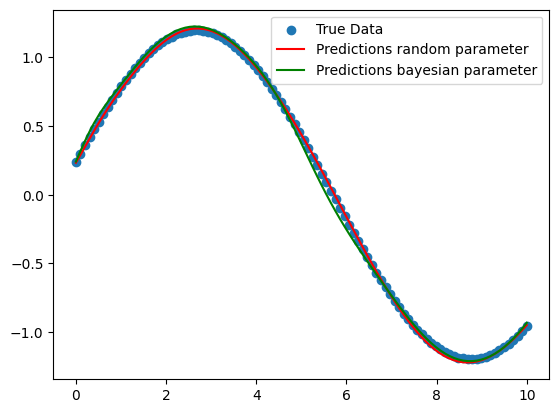

In [16]:
#Look at performance on test data
X = test["X"]

y_pred_rand = model_optimized_rand(X).squeeze(-1)
y_pred_bayes = model_optimized_bayes(X).squeeze(-1)

n = 110 #defines which initial conditions we look at?
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred_rand.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.plot(test["t_tensor"][n], y_pred_bayes.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()

# K-fold 

In [17]:
#put train and validation together so K-fold can do its work
data = {
    'args_tensor': torch.cat([train['args_tensor'], validation['args_tensor']], dim=0),
    'x0_tensor':   torch.cat([train['x0_tensor'],   validation['x0_tensor']],   dim=0),
    't_tensor':    torch.cat([train['t_tensor'],    validation['t_tensor']],    dim=0),
    'y_tensor':    torch.cat([train['y_tensor'],    validation['y_tensor']],    dim=0),
    'X':           torch.cat([train['X'],           validation['X']],           dim=0),
}

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_losses = []

for train_idx, val_idx in kf.split(data['args_tensor']):
    # Slice each tensor in the dictionary
    train_fold = {k: v[train_idx].to(device) for k, v in data.items()}
    val_fold   = {k: v[val_idx].to(device)   for k, v in data.items()}

    # Initialize model with best hyperparameters
    model = HarmonicModel(n_in=4,
                          hidden_sizes=best_params['hidden_sizes'],
                          activation=best_params['activation']).to(device)

    # Train model on this fold
    train_harmonic(model, lr=best_params['lr'], epochs=100, data=train_fold)
    loss_val = evaluate_harmonic(model, data=val_fold)
    fold_losses.append(loss_val)

average_cv_loss = sum(fold_losses) / K
print("Estimated generalization loss (K-Fold CV):", average_cv_loss)


Epoch 100/100, Loss: 0.0284
Epoch 100/100, Loss: 0.0290
Epoch 100/100, Loss: 0.0484
Epoch 100/100, Loss: 0.0286
Epoch 100/100, Loss: 0.0345
Estimated generalization loss (K-Fold CV): 0.03709709793329239


# Test the model on noisy data

In [18]:
def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset


In [19]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, validation_no_noise, test_no_noise = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

# Example: add noise with std=0.1 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
validation_noise = add_noise_to_dataset(validation_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]
y_pred_noise = best_model(X).squeeze(-1)


test_loss_bayes_noise = evaluate_harmonic(best_model, data=test_noise)
print(f"Test Loss Random optimization: {test_loss_bayes_noise:.4f}")

Test Loss Random optimization: 0.1950


/tmp/ipykernel_74132/1405275027.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


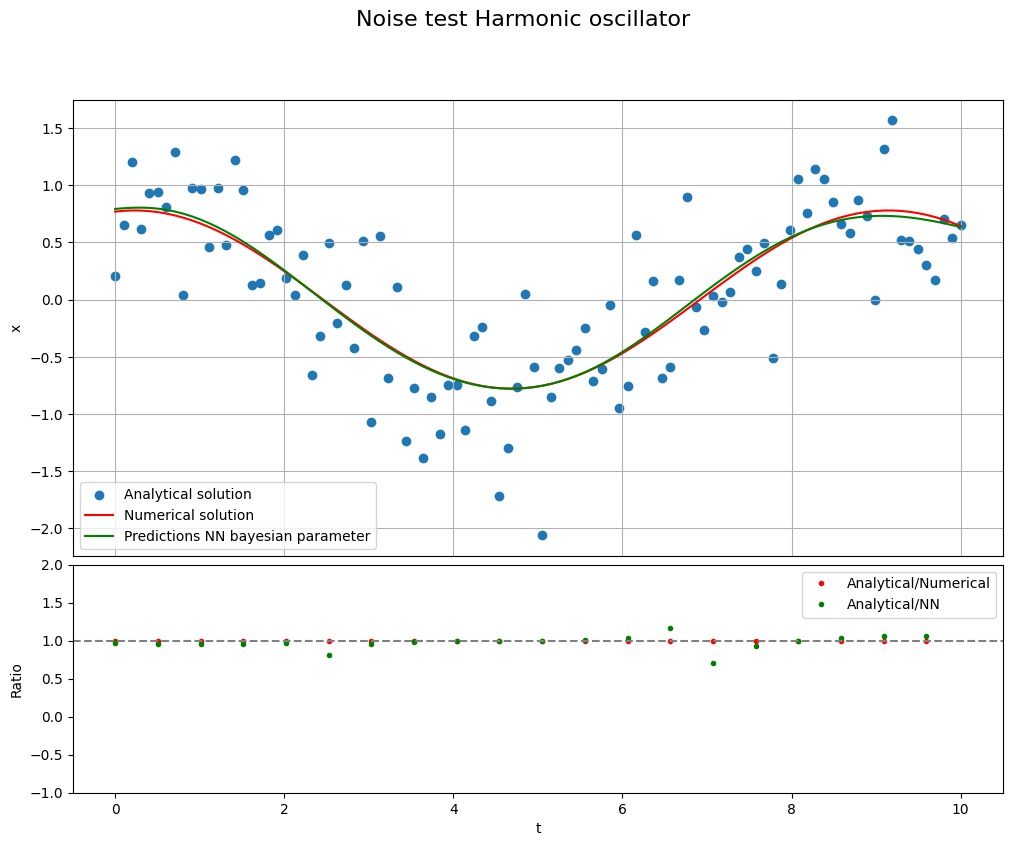

In [20]:
n = 0

y_pred_noise.to("cpu")
test_noise["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]
w = test_noise["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_no_noise["y_tensor"][n][0:, 0]/y_pred_noise.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Noise test Harmonic oscillator", fontsize=16)
plt.show()

# Test generalization

In [21]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_generalization = best_model(X).squeeze(-1)


test_loss_bayes_generalization = evaluate_harmonic(best_model, data=test_generalization)
print(f"Test Loss Random optimization: {test_loss_bayes_generalization:.4f}")

Test Loss Random optimization: 5.9508


/tmp/ipykernel_74132/2674055991.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


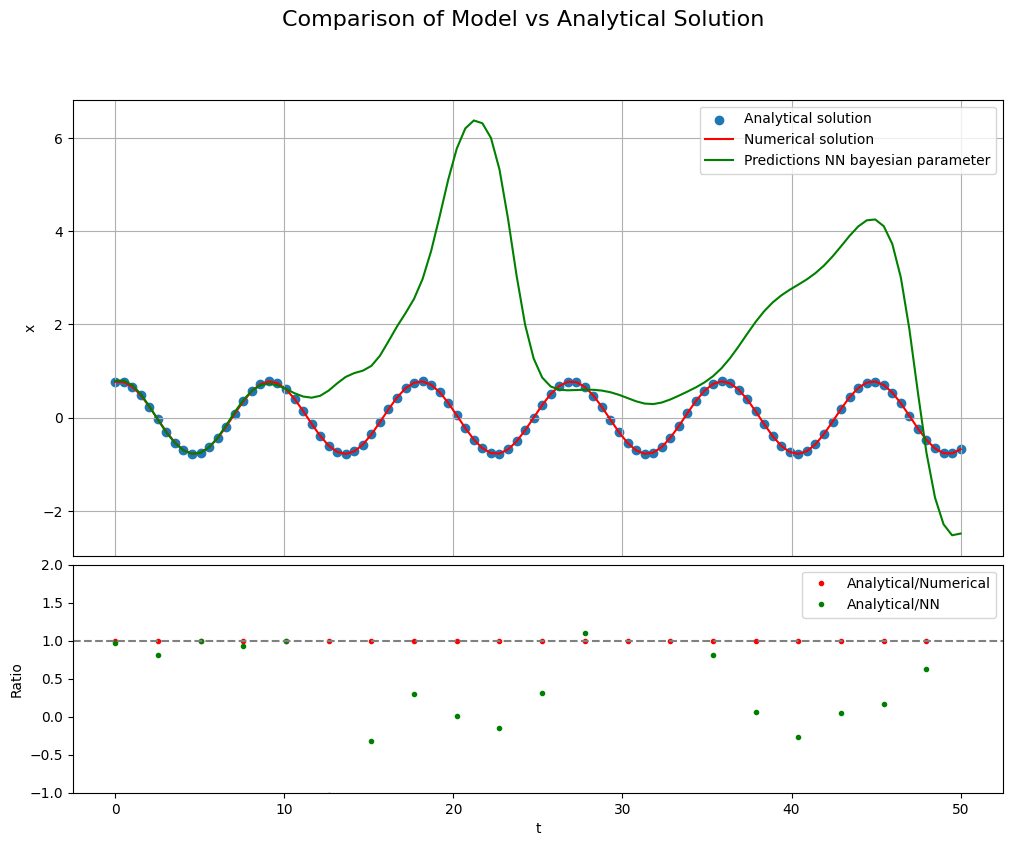

In [22]:
n = 0

y_pred_generalization.to("cpu")
test_generalization["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
w = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_generalization["y_tensor"][n][0:, 0]/y_pred_generalization.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Comparison of Model vs Analytical Solution", fontsize=16)
plt.show()

# Test physical quantities

### Energy conservation

Initial energy E0 = 1.555322e-01
Max absolute deviation = 9.937600e+00
Max relative deviation = 6.389415e+01


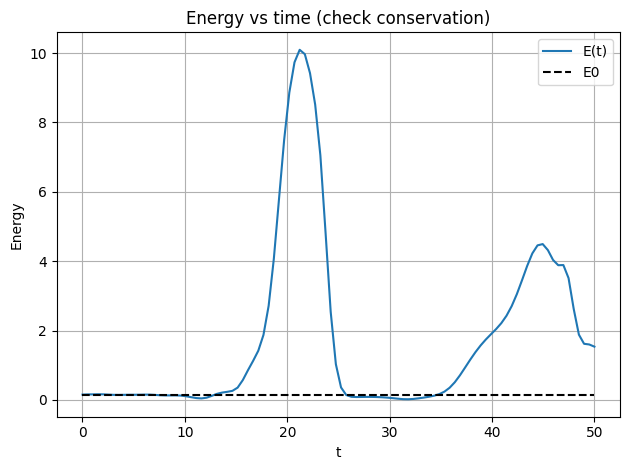

In [23]:
n = 0  # choose trajectory index

# Position
x = y_pred_generalization[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v = np.gradient(x, t)

#Energy conservation (check on generalized data)
E_t = 0.5 * v**2 + 0.5 * float(w) * x**2
E0 = E_t[0]

# diagnostics
abs_dev = np.max(np.abs(E_t - E0))
rel_dev = np.max(np.abs((E_t - E0) / E0))

print(f"Initial energy E0 = {E0:.6e}")
print(f"Max absolute deviation = {abs_dev:.6e}")
print(f"Max relative deviation = {rel_dev:.6e}")

plt.plot(test_generalization["t_tensor"][n], E_t, label='E(t)')
plt.hlines(E0, sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
#plt.ylim(0,2)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('Energy vs time (check conservation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TO DO

- Test physical quantities of model
- Make sure both models are comparable
- Compare both models